In [1]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble  import RandomForestClassifier as rfc
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pylab as pl
import matplotlib.pylab as plt

pl.rcParams['font.size'] = 20
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### data-ticket data

In [2]:
df = pd.read_csv('output_final/date_final.csv')
df["date"] = pd.to_datetime(df["date"],format='%Y-%m-%d')
print(df.shape)
df.head()

(333872, 5)


,date,zone,pickup,dropoff,tickets
0,2015-01-01,0.0,13266.0,77789.0,0.0
1,2015-01-01,1.0,1.0,0.0,10.0
2,2015-01-01,2.0,3.0,0.0,75.0
3,2015-01-01,3.0,29.0,0.0,0.0
4,2015-01-01,4.0,455.0,0.0,43.0


In [3]:
df.tail()

,date,zone,pickup,dropoff,tickets
333867,2018-06-26,105.0,0.0,0.0,85.0
333868,2018-06-27,199.0,0.0,0.0,29.0
333869,2018-06-29,105.0,0.0,0.0,72.0
333870,2018-06-29,199.0,0.0,0.0,28.0
333871,2018-06-30,199.0,0.0,0.0,19.0


### date range

In [7]:
date_range = pd.date_range('01/01/2015', '06/30/2018', freq='D' )

### Population & employment & commercial facilities

### Weather data

In [8]:
if not os.path.isfile("nycweather.csv"):
    !curl https://raw.githubusercontent.com/JunjieTsai/Datasets/master/nycwhether.csv > nycweather.csv

In [9]:
nycweather = pd.read_csv('nycweather.csv').drop('Unnamed: 0', axis=1)
nycweather = nycweather[nycweather[nycweather['Date']=='2015-01-01'].index[0] : ]
nycweather = nycweather[['Date', 'Mean.TemperatureF', 'MeanDew.PointF', 'Mean.Humidity', 'Mean.Sea.Level.PressureIn', 
                         'Mean.VisibilityMiles', 'Mean.Wind.SpeedMPH', 'PrecipitationIn']]
nycweather['PrecipitationIn'] = nycweather['PrecipitationIn'].replace('T', 0)
nycweather['PrecipitationIn'] = nycweather['PrecipitationIn'].astype(float)
nycweather = nycweather.fillna(value=0).drop(['Date'],axis=1)
nycweather.index = date_range[:len(nycweather)]
print(nycweather.shape)
nycweather.head()

(365, 7)


,Mean.TemperatureF,MeanDew.PointF,Mean.Humidity,Mean.Sea.Level.PressureIn,Mean.VisibilityMiles,Mean.Wind.SpeedMPH,PrecipitationIn
2015-01-01,34.0,12,40,30.10,10.0,17,0.00
2015-01-02,40.0,18,45,30.24,10.0,14,0.00
2015-01-03,39.0,30,71,30.45,7.0,9,0.94
2015-01-04,49.0,46,87,29.83,6.0,10,0.47
2015-01-05,37.0,12,42,30.13,10.0,20,0.00


In [10]:
nycweather.tail()

,Mean.TemperatureF,MeanDew.PointF,Mean.Humidity,Mean.Sea.Level.PressureIn,Mean.VisibilityMiles,Mean.Wind.SpeedMPH,PrecipitationIn
2015-12-27,56.0,51,82,29.97,6.0,12,0.08
2015-12-28,42.0,25,57,30.41,10.0,14,0.05
2015-12-29,42.0,40,88,30.12,6.0,12,0.66
2015-12-30,46.0,41,85,30.23,9.0,7,0.37
2015-12-31,48.0,38,71,30.06,10.0,12,0.06


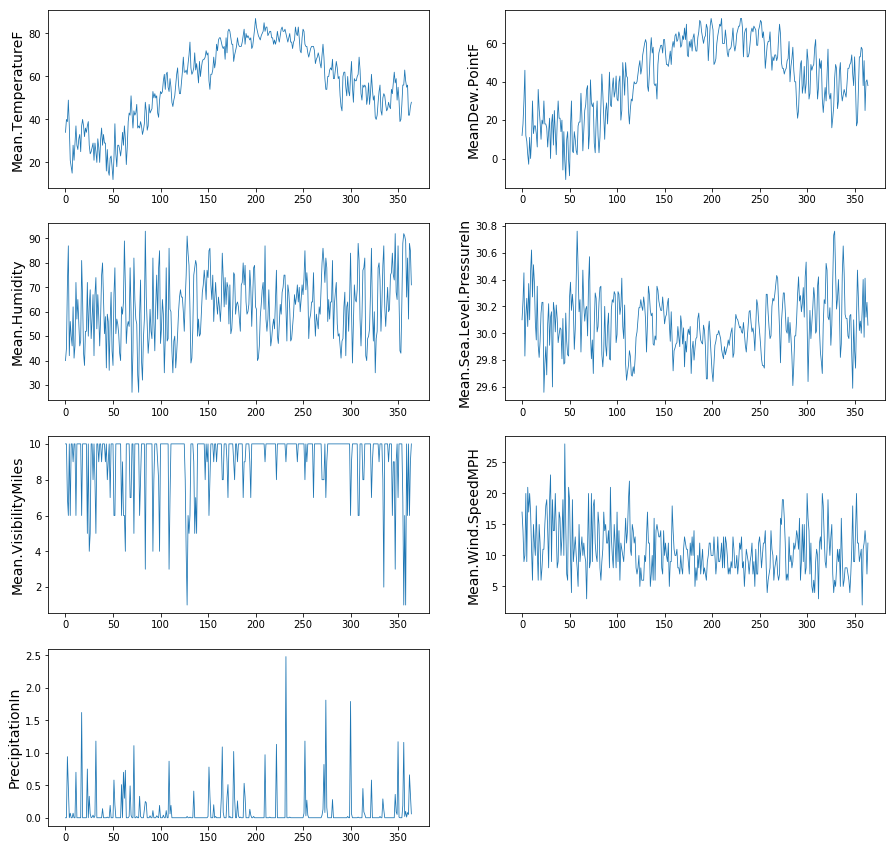

In [11]:
fig = plt.figure(figsize=(15,15))
for i in range(nycweather.shape[1]):
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(range(nycweather.shape[0]), nycweather[nycweather.columns[i]], '-', linewidth=0.8)
    ax.set_ylabel(nycweather.columns[i], fontsize=14)

###  Holiday 
**Whether the day is holiday**

In [12]:
# Generate a list of holidays over this period
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
holidays_all = calendar.holidays(date_range[0], date_range[len(date_range)-1])
holidays_all

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26',
               '2017-01-02', '2017-01-16', '2017-02-20', '2017-05-29',
               '2017-07-04', '2017-09-04', '2017-10-09', '2017-11-10',
               '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15',
               '2018-02-19', '2018-05-28'],
              dtype='datetime64[ns]', freq=None)

In [13]:
print(date_range[2])
calendar.holidays(date_range[1], date_range[2])

2015-01-03 00:00:00


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [14]:
holidays = []
for i in range(len(date_range)):
    holidays.append(len(calendar.holidays(date_range[i-1], date_range[i])))

In [15]:
holidays = pd.DataFrame(holidays)
holidays.index = date_range
holidays.columns = ['holidays']
print(holidays.shape)
holidays.head()

(1277, 1)


,holidays
2015-01-01,0
2015-01-02,1
2015-01-03,0
2015-01-04,0
2015-01-05,0


### Weekdays 
**Whether the day is weekday**<br>
refer to https://cloud.tencent.com/developer/ask/176278

In [16]:
holiday_date_list = holidays_all.date.tolist()

In [17]:
np.busday_count(date_range[0].date(), date_range[len(date_range)-1].date(), holidays = holiday_date_list)

878

In [18]:
np.busday_count(date_range[0].date(), date_range[12].date(), holidays = holiday_date_list)

7

In [19]:
weekdays = []
for i in range(len(date_range)):
    weekdays.append(np.busday_count(date_range[i-1].date(), date_range[i].date(), holidays = holiday_date_list))
weekdays[0] = weekdays[12]

In [20]:
weekdays = pd.DataFrame(weekdays)
weekdays.index = date_range
weekdays.columns = ['weekdays']
print(weekdays.shape)
weekdays.head()

(1277, 1)


,weekdays
2015-01-01,1
2015-01-02,0
2015-01-03,1
2015-01-04,0
2015-01-05,0


### Events data (Missing)
**number & magnitude of events in the date**

### Merge

In [21]:
multivar = nycweather.copy()[['Mean.TemperatureF', 'Mean.Humidity', 'Mean.Wind.SpeedMPH', 'PrecipitationIn']]
#multivar = pd.merge(y, multivar, left_index=True, right_index=True, how='right')
multivar = pd.merge(multivar, holidays, left_index=True, right_index=True, how='left')
multivar = pd.merge(multivar, weekdays, left_index=True, right_index=True, how='left')
multivar.columns = ['TemperatureF', 'Humidity',
       'WindSpeedMPH', 'PrecipitationIn', 'holidays', 'weekdays']
print(multivar.shape)
multivar.head()

(365, 6)


,TemperatureF,Humidity,WindSpeedMPH,PrecipitationIn,holidays,weekdays
2015-01-01,34.0,40,17,0.00,0,1
2015-01-02,40.0,45,14,0.00,1,0
2015-01-03,39.0,71,9,0.94,0,1
2015-01-04,49.0,87,10,0.47,0,0
2015-01-05,37.0,42,20,0.00,0,0


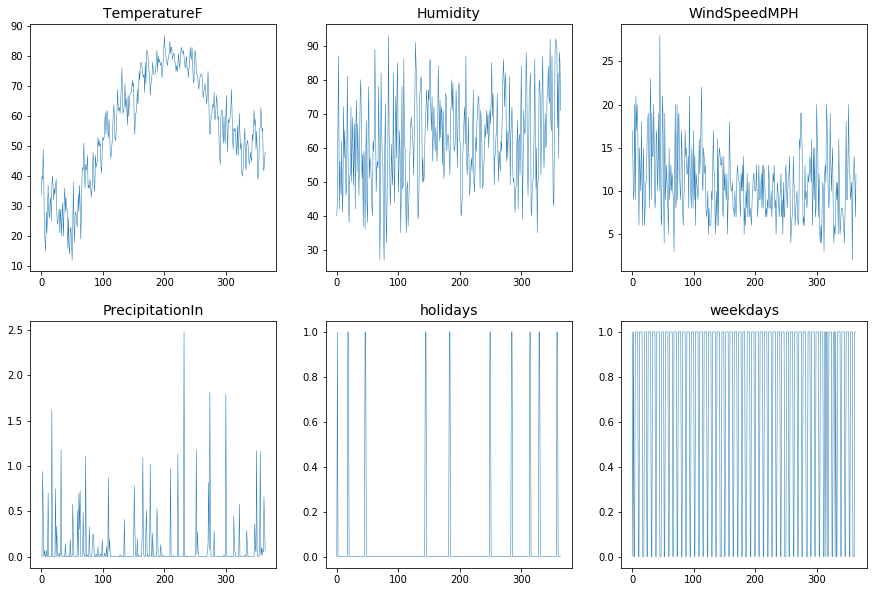

In [22]:
fig = plt.figure(figsize=(15,10))
for i in range(multivar.shape[1]):
    ax = fig.add_subplot(2,3,i+1)
    ax.plot(range(multivar.shape[0]), multivar[multivar.columns[i]], '-', linewidth=0.5)
    ax.set_title(multivar.columns[i], fontsize=14)